# Assignment 2

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday, March the 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday, April the 4th, 2022 at 23:59.

**Contributions**: In class I told you we will use DTU Learn. But Sune came up with a nicer idea!! **I'll send you a secret id by email later today** so you can add the contributions directly at the end of the notebook. They should look somewhat like this:

* id1: did this, this, and this
* id2: did that, that, and that
* id3: ...

**N.B.** It is NOT OK to say that each member contributed equally!

This Assignment is based on the last three weeks of the course (Week 6-8). Before going on please load the data with the following line. In this way, you won't need to submit anything else than the .ipynb file and we will be able to run your notebook!

In [15]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# import data
column_list = ["age", "sex", "race", "juv_fel_count", "juv_misd_count", "juv_other_count",
               "priors_count", "two_year_recid", "days_b_screening_arrest"]

recidivism = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/recidivism_dataset_sub.csv", usecols=column_list)

# clear RAM
del column_list

## Part 1: Predicting criminal recidivism: Build a Decision Tree or a Random Forest Model

The following exercises are a subset of the ones we did during Week 6. If you have doubts or need more help, go back to the Week 6 notebook. There, you will find additional hints to complete the assignment.

**Exercise 1.1:** Preprocess the data by only keeping records that have between $-30$ and $30$ days between the arrest and screening, then drop the `days_b_screening_arrest` column for the upcoming analysis.

In [17]:
# Exercise 1.1

# only keep records that have between -30 and 30 days between the arrest and screening

recidivism = recidivism.drop(recidivism[(recidivism.days_b_screening_arrest <= -30) | (recidivism.days_b_screening_arrest >= 30) | \
    (recidivism.days_b_screening_arrest.isna())].index)
    
# drop days_b_screening_arrest` for the upcoming analysis

recidivism = recidivism.drop(columns = ['days_b_screening_arrest'])

**Exercise 1.2:** Some features we are working with are categorical, so we need to deal with them by using encoders. There are many different types, but we will focus on the `OneHotEncoder` and the `LabelEncoder`: 
<br> Which encoder did you choose? Describe what it does and why you chose it.

In [ ]:
# Exercise 1.2: Feature Engineering -> one hot encoding applied on the race column and label encoding on the sex column

# Get one hot encoding of column race
one_hot = pd.get_dummies(recidivism['race'], prefix = 'race')
# Drop column race as it is now encoded
recidivism = recidivism.drop('race',axis = 1)
# Join the encoded df
recidivism = recidivism.join(one_hot)

# label encoding on the sex column (0 -> Female; 1 -> Male)
recidivism['sex'] = recidivism['sex'].astype('category')
recidivism['sex'] = recidivism['sex'].cat.codes

# clear RAM
del one_hot

**Exercise 1.2:** 
<br>
<br> **a) Describe what these encoders (`OneHotEncoder` and `LabelEncoder`) do and choose one. Which one did you choose? Why?**
<br> Label-encoding assigns an ascending numerical value to the unique categorical values of a column. The problem is that the model will misunderstand the results, interpreting, for example, an order like 0 < 1 < 2.  One-hot-encoding overcomes this problem by assigning a column to all unique categorical values of a column. If the sample (row) belongs to a certain categorical value, the value in this specific column will be one and in all the others zero.
<br> **b) What variables need to be transformed?**
<br> sex could be one hot encoded, but only two values, so label encoding is fine as well
<br> race should be one hot encoded

**Exercise 1.3:** Split the data in Train/Test sets by using a 70/30 split and `random_state=42`.

In [19]:
# Exercise 1.3
# split the data set in train and test set (70/30 split) -> balanced data set grab equal amount of each target value
# train_test_split by sklearn

X = recidivism.loc[:, ~recidivism.columns.isin(['two_year_recid'])]
#0 = defendant did not recommit a crime within two years; 1 = the defendant recommitted a crime within two years
y = recidivism['two_year_recid']

from sklearn.model_selection import train_test_split 
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42) 

# to check if equal amount of each target value
print(f'Balanced data set check for traning data: {np.unique(y_train, return_counts=True)}')
print(f'Balanced data set check for testing data: {np.unique(y_test, return_counts=True)}')

# clear RAM
del X, y, X_res, y_res

Balanced data set check for traning data: (array([0, 1], dtype=int64), array([1962, 1962], dtype=int64))
Balanced data set check for testing data: (array([0, 1], dtype=int64), array([841, 841], dtype=int64))


**Exercise 1.3:** What is a balanced data set? + Source why balanced data set for a classification task and why for a tree (best case Random Forest)

**Exercise 1.4:** Fit a model to your Train set. Choose between a `DecisionTreeClassifier` or a `RandomForestClassifier`: Describe how the model you chose works and why you chose it.

In [20]:
# Exercise 1.4
# fit a RandomForestClassifier or DecisionTreeClassifier on the data

# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

**Exercise 1.4:** 
<br>
<br>**a) Describe how the model you chose works.**
<br>
<br>**b) Describe why you chose the model.**

**Exercise 1.5: Evaluate the performance of model on the test set, i.e compute Accuracy, Precision, and Recall: What are your thoughts on these metrics? Is accuracy a good measure?**

In [21]:
# prediction
y_pred=rf.predict(X_test)

# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred).round(2))

# precision and recall
print(metrics.classification_report(y_test, y_pred))

Mean Absolute Error: 0.37 degrees.
Accuracy: 0.63
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       841
           1       0.63      0.60      0.62       841

    accuracy                           0.63      1682
   macro avg       0.63      0.63      0.63      1682
weighted avg       0.63      0.63      0.63      1682



**Exercise 1.5:** 
<br> **a) What are your thoughts on these metrics?**
<br>
<br> **b) Is accuracy a good measure?** 
<br> (Note to Philipp -> calculate accuracy using Mape to compare!)

**3.2.2 Thoughts on accuracy, precision and recall?** 
(**hint:** Since you have created a balanced dataset, the baseline performance (random guess) is 50%.)

<br> **accuracy:** "Accuracy is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right." -> only use it, when data set is balanced! -> seems rather low as it only 10 percent better then flipping a coin
<br> **precision:** "Precision is the number of correctly-identified members of a class divided by all the times the model predicted that class. In the case of Aspens, the precision score would be the number of correctly-identified Aspens divided by the total number of times the classifier predicted “Aspen,” rightly or wrongly." -> 
<br> **recall:** "Recall is the number of members of a class that the classifier identified correctly divided by the total number of members in that class. For Aspens, this would be the number of actual Aspens that the classifier correctly identified as such." ->
<br> **F1-score:** "F1 score is a little less intuitive because it combines precision and recall into one metric. If precision and recall are both high, F1 will be high, too. If they are both low, F1 will be low. If one is high and the other low, F1 will be low. F1 is a quick way to tell whether the classifier is actually good at identifying members of a class, or if it is finding shortcuts (e.g., just identifying everything as a member of a large class)." -> the model seems equally bad at predicting if the person recommitted a crime within in the next two years or not 

https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

**Exercise 1.6:** Are your results tied to the specific hyperparameter set you used? Perform a `RandomizedSearchCV` and recompute the performance metric above with the hyperparameters found. What do you observe?

In [22]:
# 3.2.3 Results toed to specific training data/ hyperparameter set?

# RandomizedSearchCV -> recompute the performance metric above with the hyperparameters found

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
print(rf.get_params())

# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)


# Random Hyperparameter Grid

# Number of trees in random forest (current random forest model n_estimators = 1000)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 1000)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

print(rf_random.best_params_)

### Evaluate Random Search

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    accuracy = metrics.accuracy_score(y_test, y_pred).round(2)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 637, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}
Model Performance
Average Error: 0.3728 degrees.
Accuracy = 0.63%.
Model Performance
Average Error: 0.3395 degrees.
Accuracy = 0.66%.
Improvement of 4.76%.


**Exercise 1.7:** Visualize the tree. There are different options to do so. You can have a look at Week 6 for hints on how to do it. What do you observe?

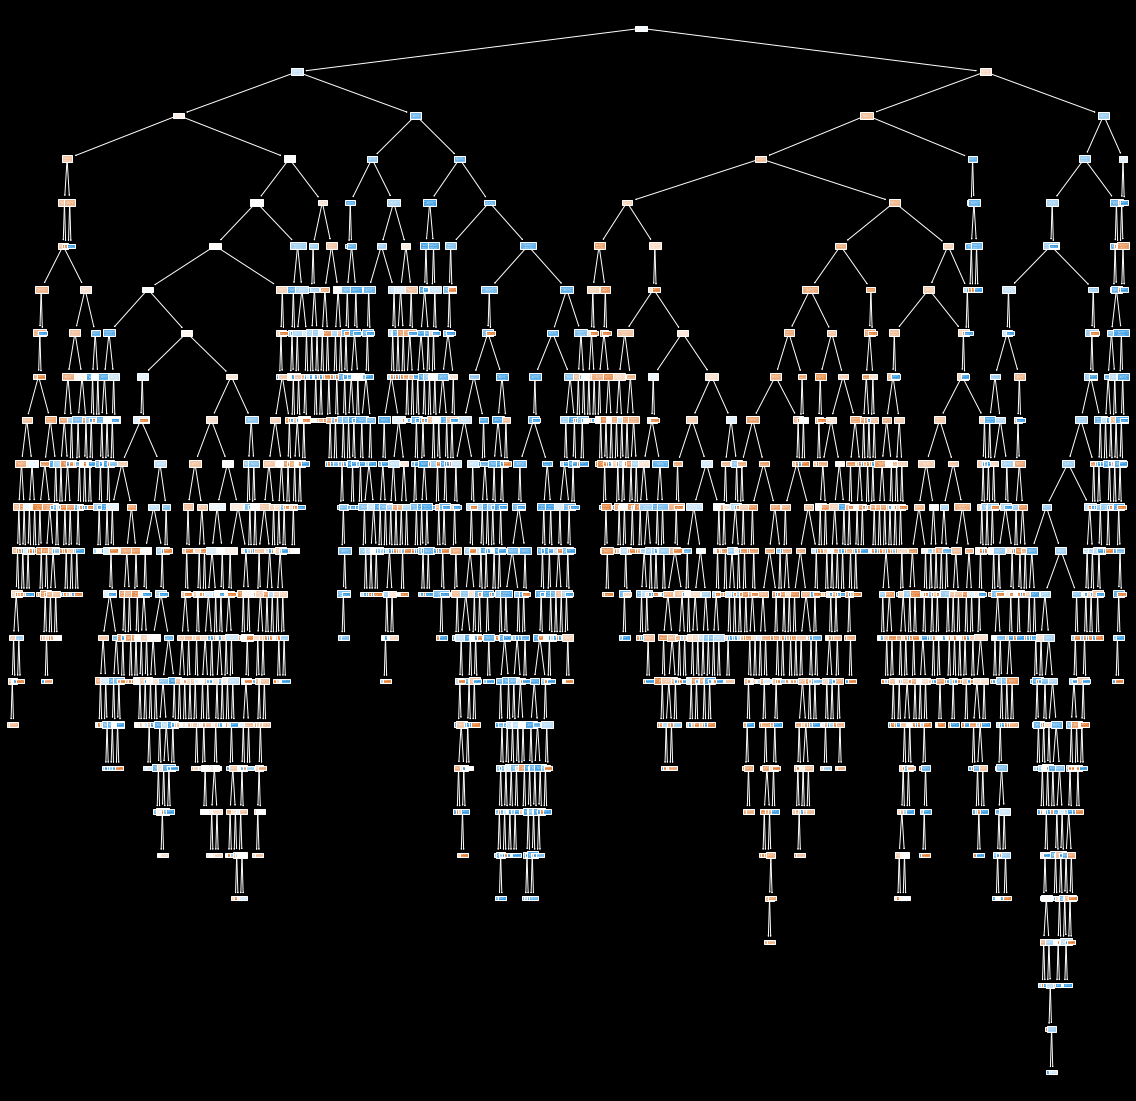

In [33]:
# Exercise 1.7 Visualize the tree

# use model.estimators_[n] as I used the random forest estimator

from sklearn import tree

rf.fit(X_train, y_train)

plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf.estimators_[0], feature_names=X_train.columns, filled=True)

**Exercise 1.7** What do you observe?
<br> Note to Philipp -> use optimized model

**Exercise 1 Wrap up** Before going on. Assign the predictions on the test set of your best model to the `y_hat` variable, and their related probabilities to the `y_prob` variable. Remember to use: `y_prob = model.predict_proba(X_test)`

In [34]:
#Exercise 1 Wrap up

**Exercise 1 Wrap up** Set a specific `random_state` in your model too. Otherwise if we rerun your results we might not be able to reproduce them!

**Note Philipp -> check if random_state 42 is everywhere + clear RAM in every cell**

## Part 2: Fairness and bias in Machine Learning

We already know the model you've built is biased. In the next exercises we are going to apply a debiasing method. Please, refer to Week 7, Part 3 for more hints on how to solve these exercises. But first a couple of questions about bias.

**Exercise 2.1** A few questions about bias.

**a) What are the most common types of data bias?**

**Note Philipp** -> all quotes from first video in Week 7
<br> 
<br> 1. Response and Activity Bias
<br> 2. Selection bias due to feedback loops
<br> 3. Bias due to system drift
<br> 4. Omitted variable bias
<br> 5. Societal Bias

**b) What are the potential bias sources/types in our case-study (i.e. recidivism)?**

**Note Philipp** -> all quotes from first video in Week 7
<br> 
<br> "1. Response and Activity Bias -> occurs in contend by humans (e.g. reviews on Amazon, tweets, posts on e.g. Facebook, Wikipedia entries...) -> bias: most data comes from a few sources, limited population, majority of users represent only a few demographic groups and geographic areas (e.g. 50% of Amazon reviews by 4% of the users)
<br> 2. Selection bias due to feedback loops -> occurs when a model itself influences the generation of data that is used to train it -> Bias: ML models direct user attention to a small subset of items, ML models record user actions on these items, this bias occurs due to the non-random subset of the items presented to users
<br> 3. Bias due to system drift -> occurs when the system generating the data goes through changes over time -> Bias: concept drift: the definition of the target changes (e.g. change in the definition of fraud?), model drift: the way users interact changes (e.g. introduction of recommended searches in google -> more searches on similar topic)
<br> 4. Omitted variable bias -> occurs in data in which critical attributes that influence the outcome are missing -> Bias: Data generated by humans not recording certain info due to lack of access/ privacy, omitted variable is correlated with target, omitted variable is also corrlated with one or more predictor variables
<br> 5. Societal Bias -> occurs in content produced by humans, whether it be social media content or curated news articles -> Bias: data inherently contains bias and stereotypes, models trained on data discriminate on race, gender, or other categories."

**Exercise 2.2:** Equal Odds. We are going to use `y_prob` to debias the ML model for African-Americans and Caucasians.

In [35]:
# Preprocessing for Part 2:

# a) split the data set in train and test set (70/30 split) -> balanced data set grab equal amount of each target value
# train_test_split by sklearn

X_Caucasians = recidivism[recidivism.race_Caucasian == 1]
X_Caucasians = X_Caucasians.drop(columns = ['two_year_recid'])
#0 = defendant did not recommit a crime within two years; 1 = the defendant recommitted a crime within two years
y_Caucasians = recidivism[recidivism.race_Caucasian == 1]
y_Caucasians = y_Caucasians['two_year_recid']

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X_Caucasians, y_Caucasians)

X_Caucasians_train, X_Caucasians_test, y_Caucasians_train, y_Caucasians_test = train_test_split(X_res, y_res, test_size=0.3, \
    stratify=y_res, random_state=42) 

# to check if equal amount of each target value 
print(np.unique(y_Caucasians_train, return_counts=True))
print(np.unique(y_Caucasians_test, return_counts=True))

y_Caucasians_pred_random = rf_random.predict(X_Caucasians_test)

# Note Philipp: one model should be enough -> calculating the confusion matrices makes sense in the end to compare it with the results
#                                             of the different tasks

# y_Caucasians_pred_grid = best_grid.predict(X_Caucasians_test)

# print('Caucasians best grid: ')
# print(pd.crosstab(y_Caucasians_test, y_Caucasians_pred_grid, rownames=['Actual'], colnames=['Predicted']))

# print('Caucasians random: ')
# print(pd.crosstab(y_Caucasians_test, y_Caucasians_pred_random, rownames=['Actual'], colnames=['Predicted']))


#######

# Take targets and predictions only for *African-Americans*.

X_African_American = recidivism.loc[recidivism['race_African-American'] == 1]
X_African_American = X_African_American.drop(columns = ['two_year_recid'])
#0 = defendant did not recommit a crime within two years; 1 = the defendant recommitted a crime within two years
y_African_American = recidivism.loc[recidivism['race_African-American'] == 1]
y_African_American = y_African_American['two_year_recid']

rus = RandomUnderSampler(random_state=42, sampling_strategy=1)
X_res, y_res = rus.fit_resample(X_African_American, y_African_American)

X_African_American_train, X_African_American_test, y_African_American_train, y_African_American_test = \
    train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=42) 

# to check if equal amount of each target value
print(np.unique(y_African_American_train, return_counts=True))
print(np.unique(y_African_American_test, return_counts=True))

y_African_American_pred_random = rf_random.predict(X_African_American_test)

# Note Philipp: one model should be enough -> calculating the confusion matrices makes sense in the end to compare it with the results
#                                             of the different tasks

# y_African_American_pred_grid = best_grid.predict(X_African_American_test)

# print('African_American best grid: ')
# print(pd.crosstab(y_African_American_test, y_African_American_pred_grid, rownames=['Actual'], colnames=['Predicted']))

# print('African_American random: ')
# print(pd.crosstab(y_African_American_test, y_African_American_pred_random, rownames=['Actual'], colnames=['Predicted']))

# b) Probabilities
y_Causiansians_prob = rf_random.predict_proba(X_Caucasians_test)[:,1] # probability for predicting one
y_African_American_prob = rf_random.predict_proba(X_African_American_test)[:,1]
# best_grid.classes_ -> to check order of the labels

(array([0, 1], dtype=int64), array([574, 575], dtype=int64))
(array([0, 1], dtype=int64), array([247, 246], dtype=int64))
(array([0, 1], dtype=int64), array([1059, 1060], dtype=int64))
(array([0, 1], dtype=int64), array([455, 454], dtype=int64))



**Exercise 2.2.1:** Define the thresholds as `ths = np.linspace(1e-5,1-1e-5, 10)` and create a function that given a threshold `th` and `y_prob` returns `y_hat` as:

$$\begin{cases}\hat{y}=1, \mbox{ if } y_{prob} > th \\ \hat{y}=0, \mbox{ otherwhise}\end{cases}    \mbox(1)$$ 

In [36]:
# Exercise 2.2.1 (Note Philipp -> I decided to write a function that creates an array with all the y_hats as columns + 
#                                 maybe you need to adjust the model name in line 8 and 9 from rf_random to what i called the model in
#                                 end of task 1 -> choose the best one (hopefully i don't forget to highlight it))

# define thresholds
ths = np.linspace(1e-5,1-1e-5, 10)

# calculate y_pred for all thresholds based on:

# y_pred = 1 if y_prob > ths
# y_pred = 0, otherwise

# function creates an array with the y_hats for the different thresholds as columns

def auc_roc_graph_array(thresholds, y_prob):

    result_array = np.zeros((len(y_prob),len(thresholds)))

    for counter, threshold in enumerate(thresholds):
        
        y_pred_threshold = np.zeros(len(y_prob))

        for i, _ in enumerate(y_prob):
         
            if y_prob[i] > threshold:
                y_pred_threshold[i] = 1
            else:
                y_pred_threshold[i] = 0
    
        result_array[:, counter] = np.copy(y_pred_threshold)

    return(result_array)

**Exercise 2.2.2:** To find the two thresholds that correct for the bias for African-Americans and Caucasians, you can either compute the distance of the ROC curve points or visually find the thresholds (as described in Week 7 Ex. 3.3). Describe the method you have used to find the thresholds (i.e. Visual or Computational) and how you used it to identify the thresholds. What thresholds did you find?

In [37]:
# Exercise 2.2.2
 
# Preparation: function to compute TPR and FPR (input y_test, y_pred)

def TPR_FPR(auc_roc_graph_array, y_test):

    y_test = y_test.values

    TPR = np.zeros(auc_roc_graph_array.shape[1])
    FPR = np.zeros(auc_roc_graph_array.shape[1])

    for threshold in range(auc_roc_graph_array.shape[1]):

        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for y_pred_index in range(auc_roc_graph_array.shape[0]):
 
            if y_test[y_pred_index]==auc_roc_graph_array[y_pred_index, threshold]==1:
                TP += 1
            if auc_roc_graph_array[y_pred_index, threshold]==1 and y_test[y_pred_index]!=auc_roc_graph_array[y_pred_index, threshold]:
                FP += 1
            if y_test[y_pred_index]==auc_roc_graph_array[y_pred_index, threshold]==0:
                TN += 1
            if auc_roc_graph_array[y_pred_index, threshold]==0 and y_test[y_pred_index]!=auc_roc_graph_array[y_pred_index, threshold]:
                FN += 1
        
        TPR[threshold] = TP/(TP + FN)
        FPR[threshold] = FP/(FP + TN)

    return(TPR, FPR)

#This function takes as an input y, y_probs, thr 
#and returns the points to plot the ROC curve and their threshold
def roc_curve(y_test, y_prob, ths):
  #initialize roc as an empty np.array
  roc = np.array([])
  #loop over thresholds
  #convert y_prob in y_hat
  y_hat = auc_roc_graph_array(ths, y_prob)
  #compute TPR and FPR
  TPR, FPR = TPR_FPR(y_hat, y_test)
  for counter, th in enumerate(ths):
    #add threshold and point to roc array
    roc = np.append(roc, [th, FPR[counter], TPR[counter]])
  #return roc
  return roc.reshape(-1, 3)

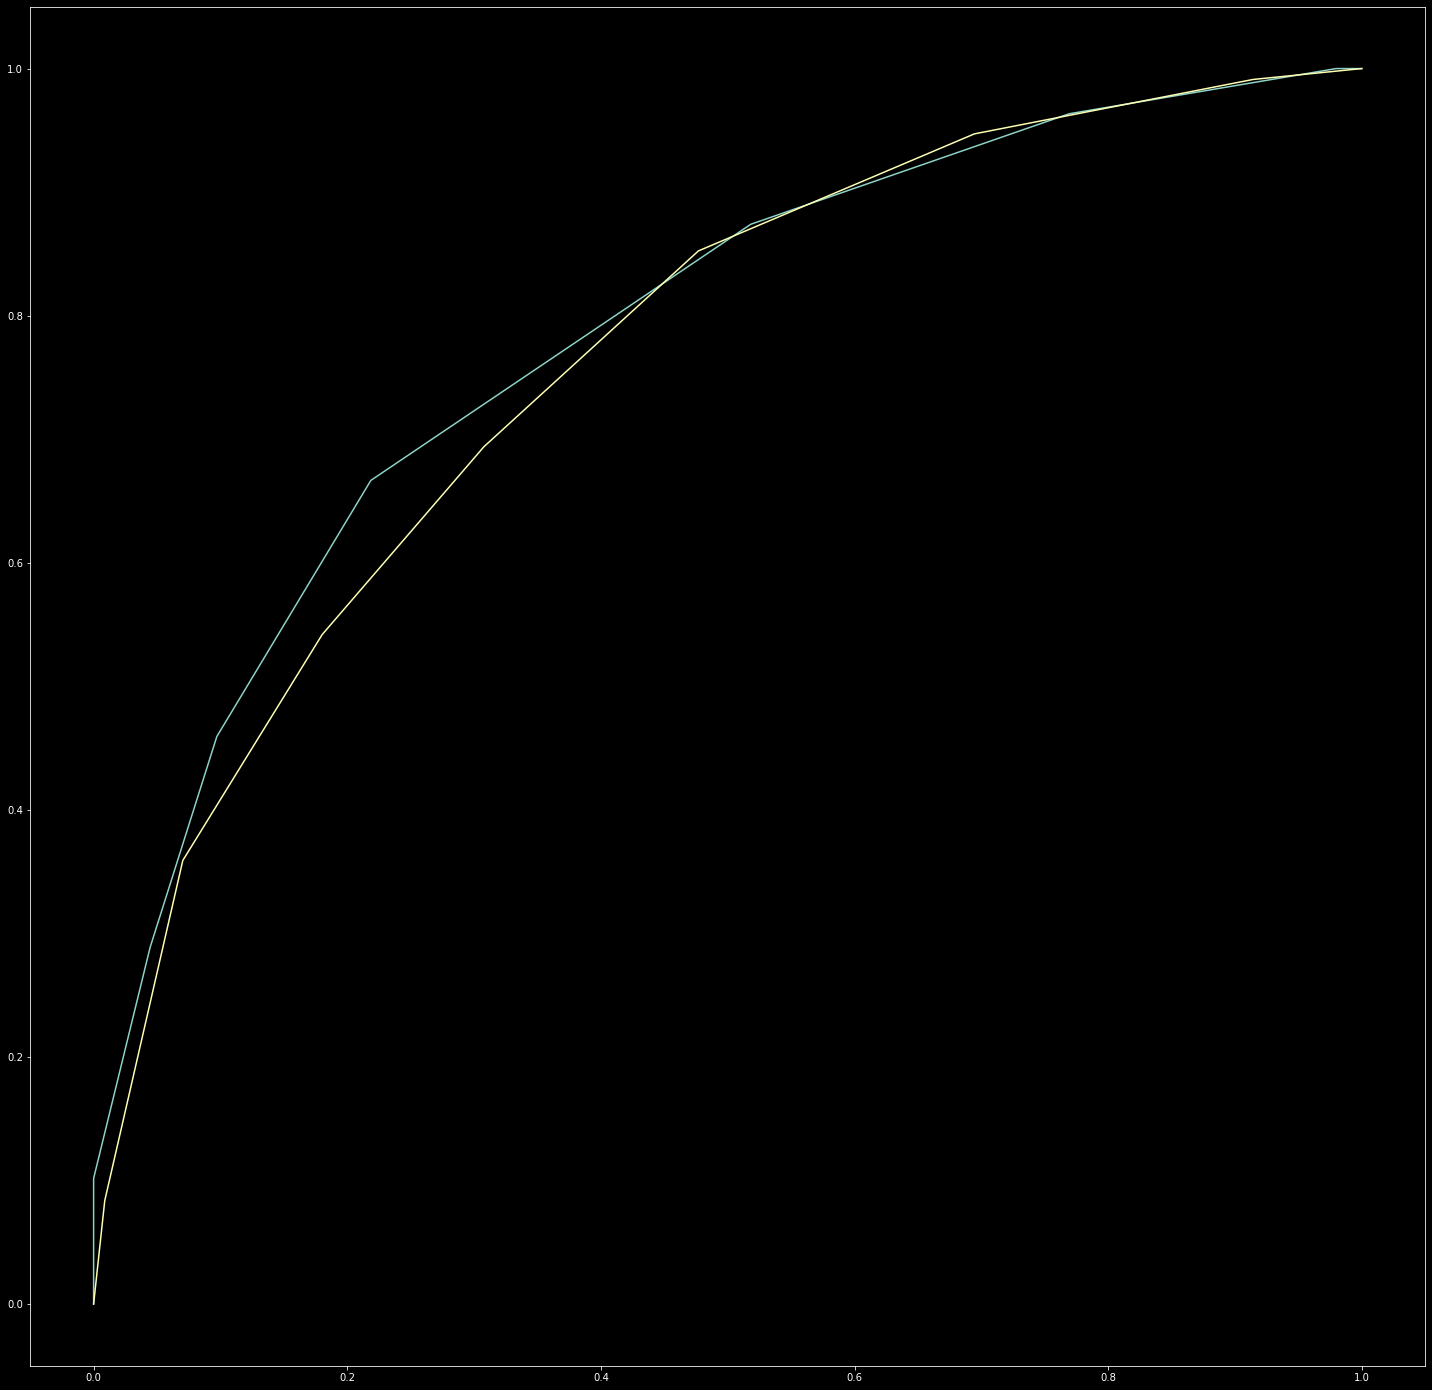

In [38]:
# Exercise 2.2.2
# Find Thresholds that lead to the closest points for the two groups on the ROC curve

# Exercise 2.2.2 a) regular plot

# calculate values and plot

Caucasians_roc_curve_values = roc_curve(y_test = y_Caucasians_test, y_prob = y_Causiansians_prob, ths = ths)
African_American_roc_curve_values = roc_curve(y_test = y_African_American_test, y_prob = y_African_American_prob, ths = ths)

plt.figure(figsize=(25,25))
plt.plot(Caucasians_roc_curve_values[:,1], Caucasians_roc_curve_values[:,2])
plt.plot(African_American_roc_curve_values[:,1], African_American_roc_curve_values[:,2])

In [41]:
# Exercise 2.2.2 b) graphically with Bokeh

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Legend, HoverTool, Title
from bokeh.io import output_notebook, show
from bokeh.models.tools import WheelZoomTool 

# roc_curves
roc_ca = roc_curve(y_test = y_Caucasians_test, y_prob = y_Causiansians_prob, ths = ths)
roc_aa = roc_curve(y_test = y_African_American_test, y_prob = y_African_American_prob, ths = ths)

roc_curves = pd.DataFrame({'FPR_AA':roc_aa[:,1], 'TPR_AA':roc_aa[:,2], 'FPR_CA':roc_ca[:,1], 'TPR_CA':roc_ca[:,2]})

roc_curves = ColumnDataSource(roc_curves)

# 
# DataFrame with columns x, y, th where x is the combined list of FPR_AA and FPR_CA, 
# y is the combined list of TPR_AA and TPR_CA, and th 

thresholds = pd.DataFrame({'x':np.concatenate((roc_aa[:,1], roc_ca[:,1])), 'y':np.concatenate((roc_aa[:,2], roc_ca[:,2])),\
    'th':np.concatenate((roc_aa[:,0], roc_ca[:,0]))})
thresholds = ColumnDataSource(thresholds)

# plotting
p = figure(tools='hover', title = 'ROC Curves')
p.line('FPR_AA', 'TPR_AA', source = roc_curves, legend_label = 'African-American')
p.line('FPR_CA', 'TPR_CA', source = roc_curves, color = 'green', legend_label = 'Caucasians')
p.circle('x','y',source=thresholds, fill_color = 'red', hover_fill_color = 'pink') 

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("FPR", "@x"),
    ("TPR", '@y'),
    ('Threshold', '@th')
    ]

p.add_layout(Title(text="FPR", align="center"), "below")
p.add_layout(Title(text="TPR", align="center"), "left")

p.legend.location = "top_left"
p.legend.click_policy="hide"

p.add_tools(WheelZoomTool())


show(p)
output_notebook()

Loading BokehJS ...

In [42]:
# Exercise 2.2.2 c) computational solution 

#This function takes as an input the points from one roc (first group) and the other (second group) and order the points by their distance in ascending order 
  
def closest_points(points1, points2):
  #initialize result
  res = list()
  #loop over points in group 1
  for pi in points1:
    #loop over points in group 2
    for pj in points2:
      #add points and their distance to res
      res.append(((pi, pj), np.linalg.norm(pi[1:] - pj[1:])))
  #return sorted result
  return sorted(res, key = lambda x: x[1])

closest_points_roc_curve = closest_points(Caucasians_roc_curve_values[:,[1,2]], African_American_roc_curve_values[:,[1,2]])

closest_points_roc_curve

[((array([1., 1.]), array([1., 1.])), 0.0),
 ((array([1., 1.]), array([1., 1.])), 0.0),
 ((array([0.97975709, 1.        ]), array([1., 1.])), 0.0),
 ((array([0.97975709, 1.        ]), array([1., 1.])), 0.0),
 ((array([0., 0.]), array([0., 0.])), 0.0),
 ((array([0., 0.]), array([0., 0.])), 0.0),
 ((array([1., 1.]), array([0.91428571, 0.99118943])), 0.008810572687224627),
 ((array([0.97975709, 1.        ]), array([0.91428571, 0.99118943])),
  0.008810572687224627),
 ((array([0.76923077, 0.96341463]), array([0.69450549, 0.94713656])),
  0.016278070269689415),
 ((array([0.        , 0.10162602]), array([0.00879121, 0.08370044])),
  0.01792557573152824),
 ((array([0.51821862, 0.87398374]), array([0.47692308, 0.85242291])),
  0.021560832348411663),
 ((array([0.21862348, 0.66666667]), array([0.30769231, 0.6938326 ])),
  0.027165932452276054),
 ((array([0.76923077, 0.96341463]), array([0.91428571, 0.99118943])),
  0.027774793166433942),
 ((array([0.76923077, 0.96341463]), array([1., 1.])), 0.03

In [ ]:
# Exercise 2.2.2 addition -> simpler way, but not asked in task -> to check results

fpr, tpr, _ = metrics.roc_curve(y_Caucasians_test, y_Causiansians_prob)
fpr_2, tpr_2, _ = metrics.roc_curve(y_African_American_test, y_African_American_prob)

#create ROC curve
plt.figure(figsize=(25,25))
plt.plot(fpr,tpr)
plt.plot(fpr_2,tpr_2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Exercise 2.2.2**
<br> **a) Describe the method you have used to find the thresholds (i.e. Visual or Computational).**

<br> **b) How you used this method to identify the thresholds?** 

<br> balanced TPR and FPR -> otherwise bad classifier -> intersections close to the "ends" of the graphs are a bad choice
<br> so find a balance between a good classifier (balanced TPR and FPR) and minimize distance between points of the different thresholds (maximize fairness of the algorithm) -> weigh up different options (second lecture video of Week 7: 27:45 min)

<br> **c) What thresholds did you find?**

<br> Threshold African-American: 0.4444 -> rather high TPR: 0.848
<br> Threshold Caucasians: 0.3333 -> rather high TPR: 0.87
<br> balance as distance is rather small, but TPRs are high -> alternatively high FPR possible, but larger distance -> the largest distance if really balanced TPRs

<br> In many applications(e.g. hiring), people care more about the true positive rate than true negative rate so many works focus on the following relaxed version:?? https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb


**Exercise 2.2.3:** Debias the model output by re-computing $\hat{y}$ with the thresholds you found. 
<br>   **Hint 1** This means that you have to take `y_prob` of your model African-Americans and apply Eq. (1) with the threshold for African-Americans, and then repeat with the different threshold for Caucasians.
<br>   **Hint 2** You shouldn't rerun your model!

In [43]:
# Exercise 2.2.3
Caucasians_auc_roc_graph_array = auc_roc_graph_array(ths, y_Causiansians_prob)
African_American_auc_roc_graph_array = auc_roc_graph_array(ths, y_African_American_prob)

th_African_American = ths[4]
th_Caucasians = ths[3]

y_hat_Afrian_American = African_American_auc_roc_graph_array[:,4]
y_hat_Caucasians = Caucasians_auc_roc_graph_array[:,3]

**Exercise 2.2.4:** Now plot the confusion matrices for African-Americans and Caucasian after you debiased the method. What do you observe? What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?

In [44]:
# Exercise 2.2.4
# NOT PLOTTED -> EXERCISE WANTS A PLOT can be done with an heatmap by sns e.g.

print('Equal Odds Caucasians: ')
print(pd.crosstab(y_Caucasians_test, y_hat_Caucasians, rownames=['Actual'], colnames=['Predicted']))

print('Equal OddsAfrican American: ')
print(pd.crosstab(y_African_American_test, y_hat_Afrian_American, rownames=['Actual'], colnames=['Predicted']))

Equal Odds Caucasians: 
Predicted  0.0  1.0
Actual             
0          119  128
1           31  215
Equal OddsAfrican American: 
Predicted  0.0  1.0
Actual             
0          238  217
1           67  387


**Exercise 2.2.4:**
<br> **a) What do you observe?**
<br> a lot of false positive values + a lot of true negative values -> does this make sense in regards of the previous concern of high TPRs in regards to the chosen thresholds? in regards to the roc graph? 
<br> **b) What do you think the problem with this debiasing method is (Refer to Week 7 for more hints)?**
<br> some groups have special rights on order to protect minorities, but if we drop the feature (or feature combination) containing this information, we loose a logical connection between the decision and the person -> it also makes it harder to compare ethnical groups, if they have different rights as we try to make them equal by applying these methods



<br> "Flaws:
It may not help closing the gap between two groups. For example, imagine group A has 100 applicants and 58 of them are qualified while group B also have 100 applicants but only 2 of them are qualified. If the company decides to accept 30 applicants and satisfies equality of opportunities, 29 offers will be conferred to group A while only 1 offer will be conferred to group B. If the job is a well-paid job, group A tends to have a better living condition and affords better education for their kids, and thus enable them to be qualified for such well-paid jobs when they grow up. The gap between group A and group B will tend to be enlarged over time."https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb

## Part 3: Communicate your story and results to others

> *Exercise 3* Fill the article below with the title, subtitles, sections, visualizations and references!
> 
>    * **Note 1** Please, have a look at Week 8 for instructions on how to complete the article and make the visualizations.
>    * **Note 2** Make sure **you add the code** that generate your visualizations! This is really important.
>    * **Note 3** You should have all the necessary inputs to make the visualizations from the exercises in Part 1 and Part 2.

# ADD YOUR TITLE HERE

**Introduction.** Write your introduction here. Think about the audience. This is an article for the general public, so you should try to make it engaging, relatable, not too technical etc.

In [23]:
#First viz here: (Week 8 Visualization 1) Interactive visualization with Bokeh

**Results from exploratory data analysis.** Write this section here. The aim is to show that the data is biased, which might have an impact on the model. Relate this part to the first visualization.

In [24]:
#Second viz here: (Week 8 Visualization 2) plot with 3 subplots (Feature importances, Confusion Matrix, Percentage difference)

**Results from the classification task.** Write this section here. The aim is to show that the model is biased as it is learning from biased data. Relate this part to the second visualization.

In [25]:
#Third viz here: (Week 8 Visualization 3) plot with 2 subplots (ROC curve and selected threshold, TPR and FPR before and after debiasing)

**Results from debiasing method.** Write this section here. The aim is to show that there are methods that can help to enhance fairness in cases as this one. Relate this part to the third visualization.

**Limitations and conclusions.** Write this part here. These are your main take aways, the end of your story, where you should also highlight possible implications/limitations of what you presented.

**References.** Any article need good sources! Whenever you make a statement, refer to data sources, previous studies, methods, etc. add a reference. 

1. reference 1
2. reference 2
3. reference 3
4. etc.

**Assignment Contributions**:

* id1
* id2
* id3